<a href="https://colab.research.google.com/github/Syed-MuhammadTaha/ImageSegmentationUNet/blob/main/ImageSegmentationUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [29]:
train_data, train_info = tfds.load('oxford_iiit_pet', split = 'train', with_info = True)
test_data, test_info = tfds.load('oxford_iiit_pet', split = 'test', with_info= True)

In [30]:
for example in train_data.take(1):
  print(example["segmentation_mask"].shape)

(500, 500, 1)


In [31]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return (input_image, input_mask)
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return (input_image, input_mask)

In [32]:
def preprocess(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask


In [33]:
test = test_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train = train_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
test

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [35]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test.batch(BATCH_SIZE)

In [36]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
      x = tf.keras.layers.Conv2D(filters = n_filters, padding = 'same', activation='relu',kernel_size=kernel_size)(x)
    return x

In [37]:
def encoder_block(inputs, n_filters, pool_size = (2, 2), dropout = 0.3):
    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPool2D(pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

In [38]:
def encoder(inputs):
    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)
    return p4, (f1, f2, f3, f4)


In [39]:
def bottleneck(inputs):
    x = conv2d_block(inputs, 1024)
    return x

In [40]:
def decoder_block(inputs, conv_output, n_filters, kernel_size = 3, strides = 2, dropout = 0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  u = tf.keras.layers.concatenate([u, conv_output])
  u = tf.keras.layers.Dropout(dropout)(u)
  u = conv2d_block(u, n_filters, kernel_size = 3)
  return u

In [41]:
def decoder(inputs, convs):
  f1, f2, f3, f4 = convs
  c6 = decoder_block(inputs,f4, 512)
  c7 = decoder_block(c6, f3, 256)
  c8 = decoder_block(c7, f2, 128)
  c9 = decoder_block(c8, f1, 64)

  output = tf.keras.layers.Conv2D(3, (1, 1), padding = 'same', activation = 'softmax')(c9)
  return output


In [42]:
def unet_model(inputs):
  inputs = tf.keras.layers.Input(shape=(128,128,3))
  encoder_output, convs = encoder(inputs)
  bottleneck_output = bottleneck(encoder_output)
  outputs = decoder(bottleneck_output, convs)
  model = tf.keras.Model(inputs = inputs, outputs = outputs)
  return model

In [43]:
model = unet_model(test_data)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64, 64, 64)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 16, 16, 256)    │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 8, 8, 512)      │              0 │ max_pooling2d_7[0][0]  │
├──────────────────────

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
NUM_EPOCHS = 20
TRAIN_LENGTH = train_info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
TEST_LENTH = test_info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE
model_history = model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.5727 - loss: 0.9697 - val_accuracy: 0.5772 - val_loss: 0.8428
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.6254 - loss: 0.8011 - val_accuracy: 0.6858 - val_loss: 0.7599
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7140 - loss: 0.6935 - val_accuracy: 0.7422 - val_loss: 0.6380
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 856ms/step - accuracy: 0.7452 - loss: 0.6273 - val_accuracy: 0.7740 - val_loss: 0.5554
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7678 - loss: 0.5813 - val_accuracy: 0.7926 - val_loss: 0.5252
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 853ms/step - accuracy: 0.7928 - loss: 0.5274 - val_accuracy: 0.8163 - val_loss: 0.4568
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8151 - loss: 0.4705 - val_accuracy: 0.8069 - val_loss: 0.4934
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 855ms/step - accuracy: 0.8164 - loss: 0.4721 - val_accuracy: 0.8370 - val_loss: 0.4296
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8380 - loss: 0.4170 - val_accuracy: 0.8393 - val_loss: 0.4138
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8397 - loss: 0.4138 - val_accuracy: 0.8444 - val_loss: 

In [51]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
# predict segmentations of images
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 58


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


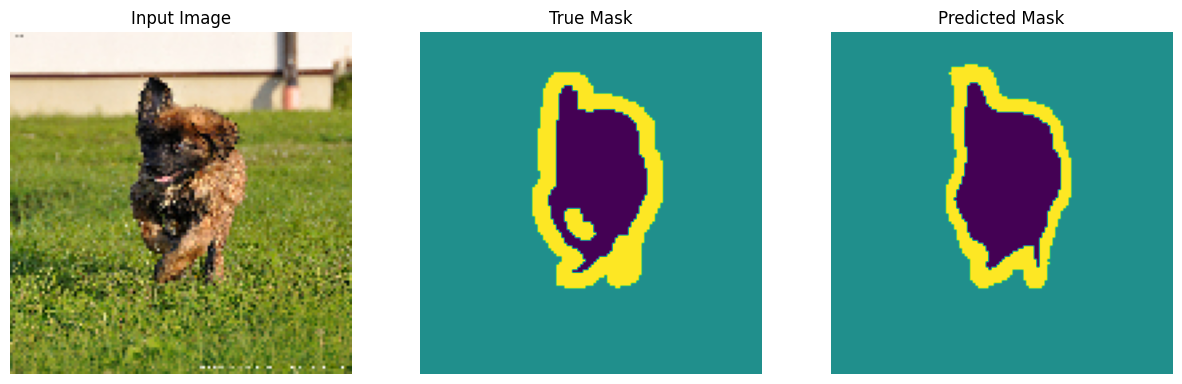

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


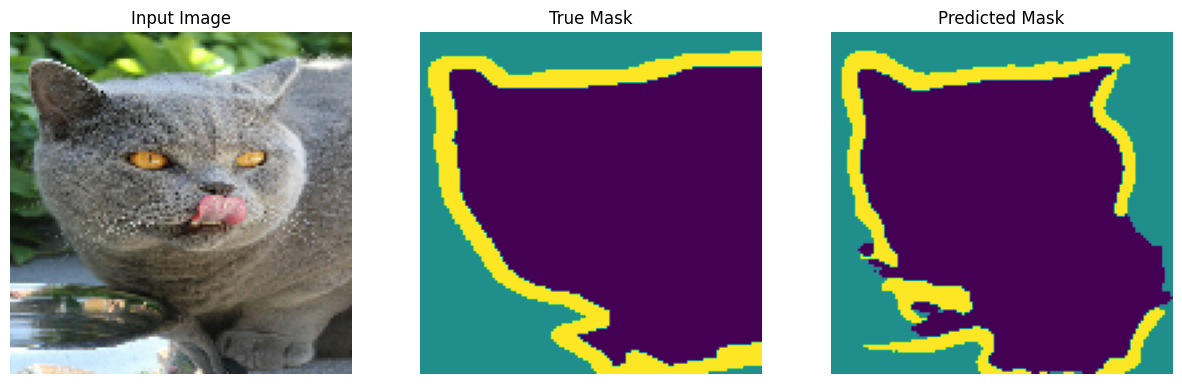

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


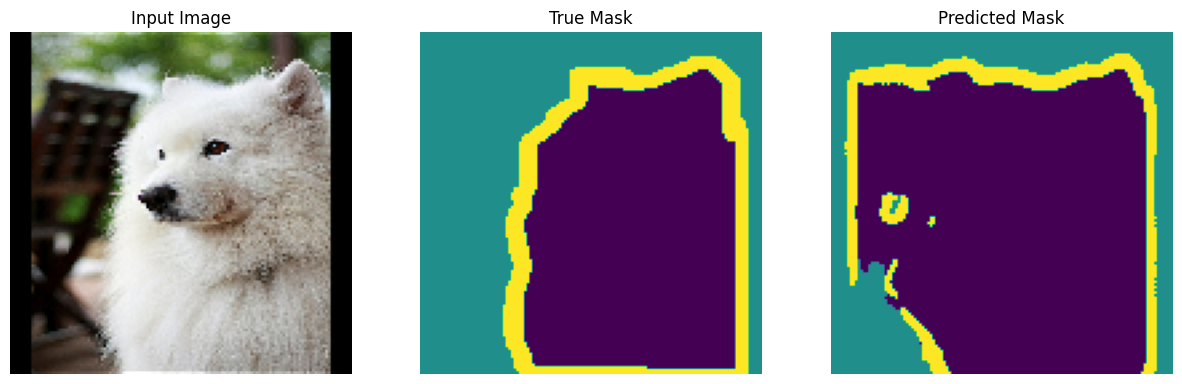

In [52]:
show_predictions(test_batches, 3)